In [1]:
import numpy as np
import pandas as pd
import math
import tqdm
import re
import string
from lightfm import LightFM

c:\users\alexa\appdata\local\programs\python\python38\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
from io import BytesIO
from PIL import Image
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
from scipy.sparse import coo_matrix, csr_matrix, hstack
from scipy.sparse.linalg import svds

# Домашнее задание

Data contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

### 1. Реализовать персональный топ  - принимает на вход пол и локацию, на выходе персональный топ   - 1 балл

Персональный топ - это топ товаров по похожим возрасту/интересам/локации. Как сделать? Разбить на сегменты по выбраным признакам. Топ делать по книгам с хорошим средним рейтингом.

### 2. На основе метода кластеризации похожих пользователей построить рекомендации (Слайд 25) - 2 балла

Нужно топ-10 рекомендаций с самой высокой оценкой. Считаем среднюю оценку для каждой книги по кластеру и выводим топ-10 книг.

### 3. Применить методы расмотренные на лекции (Совстречаемость - 2 балл, Content-based - 1 балл, Коллаборативная фильтрация - 3 балла , Матричная Факторизация - 1 балл) - 7 баллов

В совстречаемости также учитывать оценки. Вес пары книг встретившихся у пользователя - полусумма их оценок

Коллаборативную фильтрацию реализовывать как на слайде 50 презентации, посоветовав каждому пользователю топ-10 книг с самой высокой оценкой. Сделать рекомендации User-based и Item-based и сравнить.

Если совсем сложно - можно сделать как в семинарской части, поставив оценку "0", если рейтинг < 5 и "1" - в противном случае. Тогда максимум за это - 1 балл.

Для Content-based, Коллаборативной фильтрации, Матричной Факторизации реализовать U2I и I2I рекомендации

### Примечание:

Так как пользователей много - можно зафиксировать несколько произвольных и для них уже составлять рекомендации
Работоспособность I2I можно проверять на известных книгах (Гарри Поттер, Властелин Колец, Интервью с вампиром, Код-Да-Винчи, Маленький Принц)
Рейтинг книг обязательно нужно учитывать

Не забываем также предобработать данные - выкинуть выбросы-пользователей и выбросы-книги.

# Дедлайн 30 ноября
# Жесткий дедлайн - 7 декабря

Выводить в качестве рекомендаций лучше названия книг, картинки (если они есть) и соответствующие метрики близости.
Присылать в виде ноутбука


In [3]:
books = pd.read_csv("BX-Books.csv")

c:\users\alexa\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
books.head(1)

ISBN           Book-Title         Book-Author Year-Of-Publication  \
0  0195153448  Classical Mythology  Mark P. O. Morford                2002   

                 Publisher                                        Image-URL-S  \
0  Oxford University Press  http://images.amazon.com/images/P/0195153448.0...   

                                         Image-URL-M  \
0  http://images.amazon.com/images/P/0195153448.0...   

                                         Image-URL-L  
0  http://images.amazon.com/images/P/0195153448.0...

In [5]:
interactions = pd.read_csv("BX-Book-Ratings.csv", sep=";", encoding = "ISO-8859-1")

In [6]:
interactions.head(5)

User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6

In [7]:
users = pd.read_csv('BX-Users.csv', delimiter=';', encoding = 'ISO-8859-1')
users.head(3)

User-ID                         Location   Age
0        1               nyc, new york, usa   NaN
1        2        stockton, california, usa  18.0
2        3  moscow, yukon territory, russia   NaN

In [8]:
interactions = interactions[interactions["Book-Rating"] != 0]
interactions = interactions[interactions["Book-Rating"] < 11]

In [9]:
books_meets = interactions.groupby("ISBN")["User-ID"].count().reset_index().rename(columns={"User-ID": "user_num"})
books_meets.head(3)

ISBN  user_num
0   0330299891         1
1   0375404120         1
2   9022906116         1

In [10]:
user_meets = interactions.groupby("User-ID")["ISBN"].count().reset_index().rename(columns={"ISBN": "books_num"})
user_meets.head(3)

User-ID  books_num
0        8          7
1        9          1
2       10          1

In [11]:
interactions = interactions.merge(books_meets, on=["ISBN"]).merge(user_meets, on=["User-ID"])

In [12]:
interactions = interactions[(interactions["user_num"] > 5) & 
                            (interactions["books_num"] > 5) &
                            (interactions["books_num"] < 200)]

In [13]:
interactions.head(5)

User-ID        ISBN  Book-Rating  user_num  books_num
5       86583  3404139178            9         8         18
6       86583  3453061187            8        13         18
13      86583  3426609061            7         8         18
8555    16877  038550120X            9        81         10
8556    16877  034539657X            7        26         10

In [14]:
interactions = interactions.merge(books[["ISBN", "Image-URL-M", "Book-Title"]].rename(
    columns={"Image-URL-M": "picture_url"}), on=["ISBN"])

In [15]:
interactions.head(3)

User-ID        ISBN  Book-Rating  user_num  books_num  \
0    86583  3404139178            9         8         18   
1   132500  3404139178           10         8         43   
2    66483  3404139178           10         8         83   

                                         picture_url  \
0  http://images.amazon.com/images/P/3404139178.0...   
1  http://images.amazon.com/images/P/3404139178.0...   
2  http://images.amazon.com/images/P/3404139178.0...   

                                    Book-Title  
0  Das Lacheln der Fortuna: Historischer Roman  
1  Das Lacheln der Fortuna: Historischer Roman  
2  Das Lacheln der Fortuna: Historischer Roman

In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [17]:
interactions["product_id"] = le.fit_transform(interactions["ISBN"])
interactions["vid"] = le.fit_transform(interactions["User-ID"])
users = users.loc[users['User-ID'].isin(le.classes_)]
#users["vid"] = le.transform(users["User-ID"])

In [18]:
vectorizer = CountVectorizer(analyzer='word',ngram_range=(1,1), binary=True, min_df=3, token_pattern=r'[^\d\W]+\b')

In [19]:
vectorized = vectorizer.fit_transform(users['Location'].values)

In [20]:
count_vect_df = pd.DataFrame(vectorized.astype(np.int8).toarray(), columns=vectorizer.get_feature_names())

In [21]:
users = users.reset_index(drop=True)
users

User-ID                              Location   Age
0            8              timmins, ontario, canada   NaN
1           99              franktown, colorado, usa  42.0
2          114           ligonier, pennsylvania, usa  57.0
3          242  neuffen, baden-wuerttemberg, germany  37.0
4          243           arden hills, minnesota, usa   NaN
...        ...                                   ...   ...
10955   278668                 madrid, madrid, spain  48.0
10956   278694              montgomery, alabama, usa  57.0
10957   278843          pismo beach, california, usa  28.0
10958   278851                    dallas, texas, usa  33.0
10959   278854                 portland, oregon, usa   NaN

[10960 rows x 3 columns]

In [22]:
users_new = pd.concat([users, count_vect_df], axis=1)
del(count_vect_df)
users_new = users_new.drop(['User-ID', 'Location'], axis=1)
users_new["Age"] = users_new["Age"].fillna(value=users_new.Age.median())
users_new["Age"] = users_new["Age"]/users_new["Age"].max()

In [23]:
users_new

Age  a  aachen  aargau  abbotsford  aberdeen  abruzzo  acton  \
0      0.135246  0       0       0           0         0        0      0   
1      0.172131  0       0       0           0         0        0      0   
2      0.233607  0       0       0           0         0        0      0   
3      0.151639  0       0       0           0         0        0      0   
4      0.135246  0       0       0           0         0        0      0   
...         ... ..     ...     ...         ...       ...      ...    ...   
10955  0.196721  0       0       0           0         0        0      0   
10956  0.233607  0       0       0           0         0        0      0   
10957  0.114754  0       0       0           0         0        0      0   
10958  0.135246  0       0       0           0         0        0      0   
10959  0.135246  0       0       0           0         0        0      0   

       adelaide  adige  ...  yorktown  ypsilanti  yukon  zaragoza  zealand  \
0             0      0  ...         0          0      0         0        0   
1             0      0  ...         0          0      0         0        0   
2             0      0  ...         0          0      0         0        0   
3             0      0  ...         0          0      0         0        0   
4             0      0  ...         0          0      0         0        0   
...         ...    ...  ...       ...        ...    ...       ...      ...   
10955         0      0  ...         0          0      0         0        0   
10956         0      0  ...         0          0      0         0        0   
10957         0      0  ...         0          0      0         0        0   
10958         0      0  ...         0          0      0         0        0   
10959         0      0  ...         0          0      0         0        0   

       zeeland  zug  zuid  zurich  zürich  
0            0    0     0       0       0  
1            0    0     0       0       0  
2            0    0     0       0       0  
3            0    0     0       0       0  
4            0    0     0       0       0  
...        ...  ...   ...     ...     ...  
10955        0    0     0       0       0  
10956        0    0     0       0       0  
10957        0    0     0       0       0  
10958        0    0     0       0       0  
10959        0    0     0       0       0  

[10960 rows x 1218 columns]

In [24]:
interactions.head(3)

User-ID        ISBN  Book-Rating  user_num  books_num  \
0    86583  3404139178            9         8         18   
1   132500  3404139178           10         8         43   
2    66483  3404139178           10         8         83   

                                         picture_url  \
0  http://images.amazon.com/images/P/3404139178.0...   
1  http://images.amazon.com/images/P/3404139178.0...   
2  http://images.amazon.com/images/P/3404139178.0...   

                                    Book-Title  product_id   vid  
0  Das Lacheln der Fortuna: Historischer Roman       10397  3445  
1  Das Lacheln der Fortuna: Historischer Roman       10397  5248  
2  Das Lacheln der Fortuna: Historischer Roman       10397  2622

In [25]:
csr_rates = coo_matrix((interactions["Book-Rating"], (interactions["vid"], interactions["product_id"])), 
                            shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))

In [26]:
csr_rates.shape

(10960, 10712)

### 1. Персональный топ
Топ определяется по средней оценке n ближайших соседей.
Признаком определения ближайших соседей является возраст и местоположение пользователя

In [27]:
from sklearn.neighbors import NearestNeighbors

def print_img(measure_des, top_id_des, interactions, top_n=10):
    fig = plt.figure(figsize=(20, 4.5*math.ceil(top_n/5)))
    for idx, top_id in enumerate(top_id_des[:top_n]):
        url = interactions.loc[interactions['product_id'] == top_id, 'picture_url'].values[0]
        title = interactions.loc[interactions['product_id'] == top_id, 'Book-Title'].values[0]
        try:
            r = requests.get(url)
            im = Image.open(BytesIO(r.content))
        except:
            print('Something went wrong with {url}'.format(url=i))
            continue
        a = fig.add_subplot(math.ceil(top_n/5), 5, idx + 1)
        if measure_des[idx] is not None:
            a.title.set_text("raiting = {}\nTitle = {}\nBook_id = {}".
                             format(measure_des[idx], title[:20]+'...', top_id))
        plt.imshow(im)
        plt.axis('off')
    plt.show()
    

def get_top1(features, users, csr_rates, interactions,  minpts=100):
    # строим модель ближайших соседей, определяем minpts ближайщих соседей для входного наблюдения
    neigh = NearestNeighbors(n_neighbors=minpts)
    neigh.fit(users)
    d, idx = neigh.kneighbors([features], return_distance=True)
    print('distances to nearest neighbors: \n',d)
    #print(idx)
    # для всех ближайших соседей суммируем рейтинги фильмов и делим на число оценок. Получаем ср. рейтинг
    ratings = np.zeros(csr_rates.shape[1])
    divisor = np.zeros(csr_rates.shape[1])
    
    for i in idx[0]:
        ratings = ratings + csr_rates.getrow(i).toarray()[0]
        divisor[csr_rates.getrow(i).toarray()[0] != 0] = divisor[csr_rates.getrow(i).toarray()[0] != 0] + 1

    # Не считаем, если книга была оценена меньше 2 раз  
    divisor[divisor < 2] = -1
    ratings = ratings/divisor
    ratings_descending = np.flip(np.sort(ratings))
    top_id_descending = np.flip(np.argsort(ratings))
#     print(ratings_descending)
#     print(np.unique(ratings_descending))
#     print(top_id_descending)
    print('top books: \n')
    print_img(ratings_descending, top_id_descending, interactions)

Смотрим топ для первого пользователя.

distances to nearest neighbors: 
 [[0.         0.         0.02459016 0.02459016 0.02868852 0.03278689
  0.03278689 0.03688525 0.03688525 0.03688525 0.03688525 0.03688525
  0.03688525 0.03688525 0.04098361 0.04098361 0.04508197 0.04508197
  0.04918033 0.06147541 0.06557377 0.06557377 0.07377049 0.09836066
  0.11065574 1.         1.0000084  1.0000084  1.0000084  1.0000084
  1.0000084  1.00003359 1.00003359 1.00003359 1.00003359 1.00007558
  1.00007558 1.00007558 1.00013436 1.00020993 1.00020993 1.00020993
  1.00020993 1.00020993 1.00030229 1.00030229 1.00030229 1.00041143
  1.00041143 1.00041143 1.00041143 1.00053735 1.00053735 1.00053735
  1.00068003 1.00068003 1.00068003 1.00068003 1.00068003 1.00068003
  1.00068003 1.00068003 1.00068003 1.00068003 1.00068003 1.00068003
  1.00068003 1.00068003 1.00068003 1.00068003 1.00068003 1.00068003
  1.00068003 1.00068003 1.00068003 1.00068003 1.00068003 1.00068003
  1.00068003 1.00068003 1.00068003 1.00068003 1.00068003 1.00068003
  1.00068003 1.

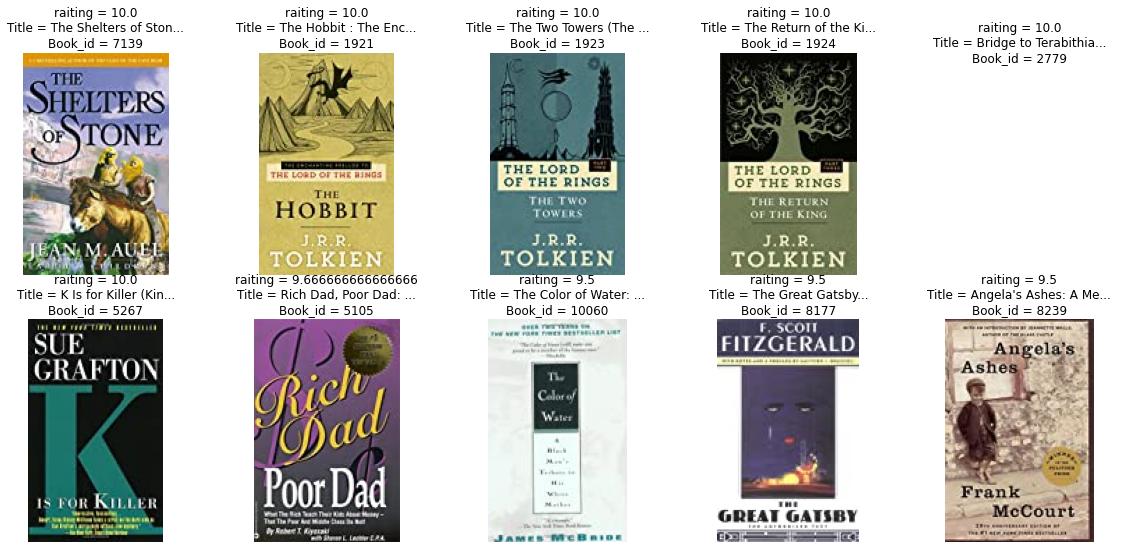

In [28]:
get_top1(users_new.iloc[1], users_new, csr_rates, interactions)

### 2. Также персональный топ, определенный методом кластеризации, но с другими признаками
Топ определяется по средней оценке n ближайших соседей. Признаком определения ближайших соседей является возраст, местоположение пользователя и его оценки(предпочтения)

Добавляем новые признаки

In [29]:
users_new1 = pd.concat([users_new, pd.DataFrame.sparse.from_spmatrix(csr_rates/10)], axis=1)
#users_new1 = pd.DataFrame.sparse.from_spmatrix(csr_rates/10)

c:\users\alexa\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


distances to nearest neighbors: 
 [[0.         2.07226927 2.08586266 2.11455918 2.12151433 2.12151433
  2.121641   2.1447963  2.14715364 2.16133304 2.17976157 2.18663223
  2.20278113 2.20484932 2.22516528 2.24188839 2.25196814 2.26054577
  2.26066465 2.26083182 2.26083182 2.26083182 2.26083182 2.26125897
  2.2614818  2.26160434 2.26304232 2.26518763 2.26578446 2.27774659
  2.28502965 2.28545228 2.30470815 2.30680743 2.31318461 2.31323907
  2.31330078 2.31330078 2.31330078 2.31330078 2.31330078 2.31330078
  2.31330078 2.31330078 2.3144586  2.31492665 2.31509715 2.3152749
  2.31534512 2.31546119 2.32186886 2.32234625 2.32623312 2.33461344
  2.34123056 2.34524011 2.34549793 2.34549793 2.34549793 2.34549793
  2.34556596 2.34572349 2.34601348 2.34612445 2.34726965 2.34804006
  2.35613253 2.3582537  2.36311234 2.36671936 2.36671936 2.36671936
  2.36686129 2.36745733 2.37094085 2.37393083 2.37594548 2.37950255
  2.38117618 2.38120792 2.38126435 2.38130315 2.38146185 2.38146185
  2.38146185 2.

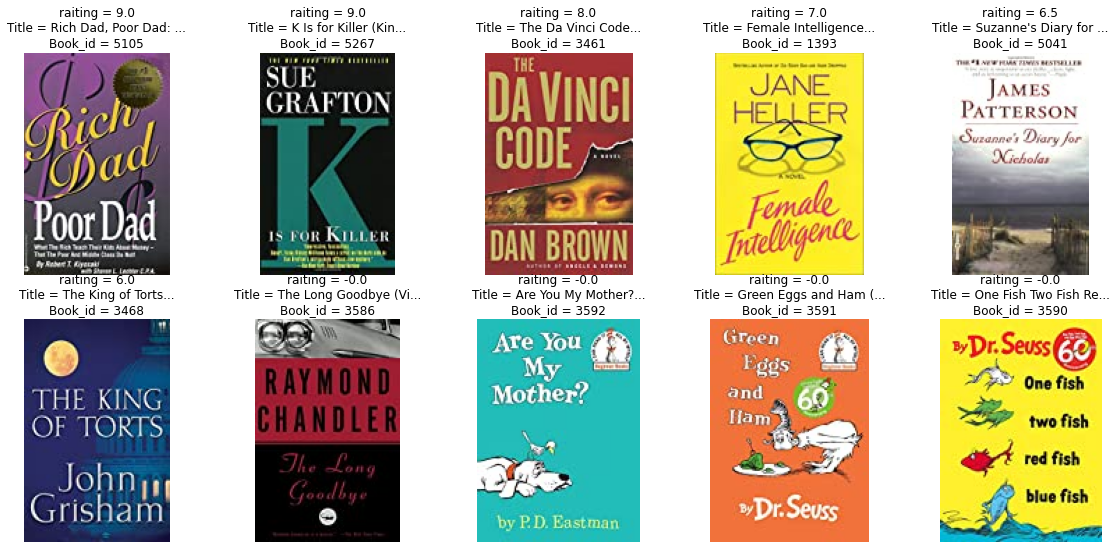

In [30]:
get_top1(users_new1.iloc[1], users_new1, csr_rates, interactions)

Можно заметить, что количество книг с ненулевым рейтингом при рассмотрении предпочтений пользователя значительно уменьшилось.

Я так понимаю, это связано с тем, что похожих пользователей по интересам (т.е. чтобы и оценки и просмотренные фильмы совпадали) очень мало. Таким образом, появляется много ближайших соседей, которые просматривали разные фильмы, т.е. у которых мало количество пересечений по фильмам

### 3.1 Совстречаемость

In [31]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def rec_imaging(product_ids, content_dict, measure=None, top_n=5):
    picture_urls = [content_dict[i] for i in product_ids]
    cnt = 0
    for idx, chunk in enumerate(chunks(picture_urls, top_n)):
        fig = plt.figure(figsize=(20, 4))
        for n, i in enumerate(chunk):
            try:
                r = requests.get(i)
                im = Image.open(BytesIO(r.content))

            except:
                print('Something went wrong with {url}'.format(url=i))
                continue

            a = fig.add_subplot(1, top_n, n + 1)
            if measure is not None:
                a.title.set_text("measure = {}".format(np.round(measure[cnt], 4)))
                cnt += 1
            plt.imshow(im)
            plt.axis('off')
        plt.show()

In [32]:
class Recomendations():
    def __init__(self, Int):
        self.product_id_to_url = {}
        for i in Int[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]
        self.interactions = Int
        
    def coocurrency_count(self):
        Int = self.interactions[["vid", "product_id", "Book-Rating"]].drop_duplicates()
        #user_products = Int.groupby(["vid"])["product_id"].apply(list).reset_index()
        user_products = pd.concat([Int.groupby(["vid"])["product_id"].apply(list).reset_index(),
          Int.groupby(["vid"])["Book-Rating"].apply(list).reset_index()['Book-Rating']], axis=1)
        product_num = [len(i) for i in user_products["product_id"]]
        user_products["prod_num"] = product_num
        user_products = user_products[user_products["prod_num"] > 1]
        #print(user_products)

        cooc = {}
        for i in tqdm.tqdm_notebook(user_products.values):
            for j in range(len(i[1])):
                for k in range(len(i[1])):
                    # Также смотрим на рейтинг
                    if j != k:
                        try:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] += (i[2][j] + i[2][k])/2 #учет оценок
                        except:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] = 1
        cooc_list = []
        for i, j in cooc.items():
            if j != 1:
                cooc_list.append(i.split("_") + [j])
        
        self.cooc_rec = pd.DataFrame(cooc_list, columns=["item1", "item2", "measure"])
    
    def get_rec(self, i, show=False):
        recs = self.cooc_rec[self.cooc_rec["item1"] == str(i)]\
                            .sort_values("measure", ascending=False)\
                            .head(10)
        print(u"Для товара")
        rec_imaging([i], self.product_id_to_url)
        print(u"Такие рекомендации")
        rec_imaging(recs["item2"].values.astype(int), self.product_id_to_url, 
                         recs["measure"].values.astype(int))

In [33]:
cooc_rec = Recomendations(interactions)
cooc_rec.coocurrency_count()

<ipython-input-32-c1fd7a8cdd0a>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(user_products.values):


Думаю, что похоже

Для товара


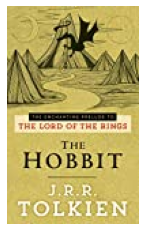

Такие рекомендации


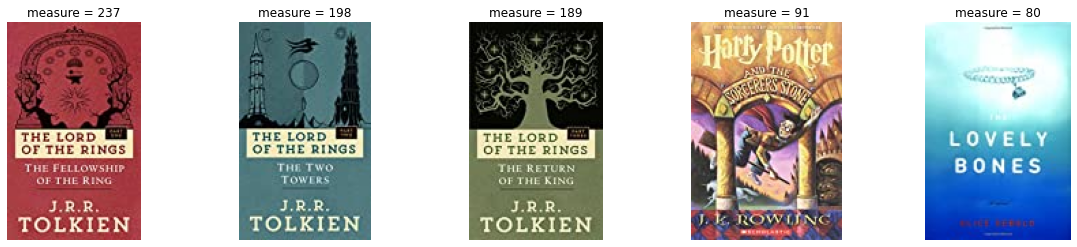

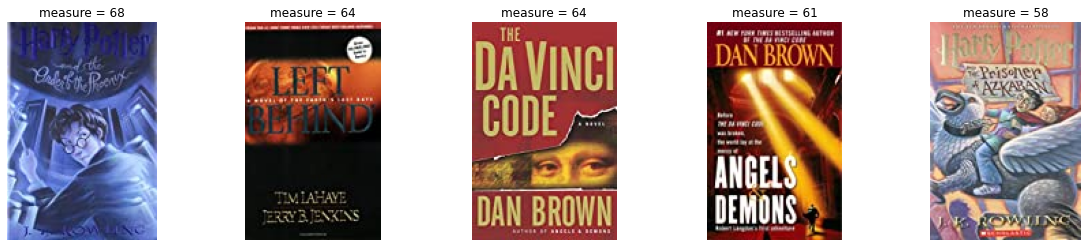

In [34]:
cooc_rec.get_rec(1921)

### 3.2 Content-based

In [35]:
books_text_url = books['Image-URL-M'].copy().to_frame()
books_text_url['text'] = books['Book-Title'] + ' ' + books['Book-Author'] + ' ' + books['Publisher']
books_text_url = books_text_url.rename(columns={"Image-URL-M": "picture_url"})
books_text_url = books_text_url.fillna('')
interactions_text = interactions.copy()
interactions_text = interactions_text.merge(books_text_url, on=['picture_url'])
books_text_url.head(3)

picture_url  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   

                                                text  
0  Classical Mythology Mark P. O. Morford Oxford ...  
1  Clara Callan Richard Bruce Wright HarperFlamin...  
2  Decision in Normandy Carlo D'Este HarperPerennial

In [36]:
interactions_text.head(3)

User-ID        ISBN  Book-Rating  user_num  books_num  \
0    86583  3404139178            9         8         18   
1   132500  3404139178           10         8         43   
2    66483  3404139178           10         8         83   

                                         picture_url  \
0  http://images.amazon.com/images/P/3404139178.0...   
1  http://images.amazon.com/images/P/3404139178.0...   
2  http://images.amazon.com/images/P/3404139178.0...   

                                    Book-Title  product_id   vid  \
0  Das Lacheln der Fortuna: Historischer Roman       10397  3445   
1  Das Lacheln der Fortuna: Historischer Roman       10397  5248   
2  Das Lacheln der Fortuna: Historischer Roman       10397  2622   

                                                text  
0  Das Lacheln der Fortuna: Historischer Roman Re...  
1  Das Lacheln der Fortuna: Historischer Roman Re...  
2  Das Lacheln der Fortuna: Historischer Roman Re...

In [37]:
PUNCT_TO_REMOVE = string.punctuation + '1234567890«»—�'
def remove_punctuation(text):
    text = text.translate(str.maketrans(PUNCT_TO_REMOVE, ' '*len(PUNCT_TO_REMOVE)))
    return " ".join(text.split())

books_text_url["text"] = books_text_url.text.apply(lambda text: remove_punctuation(text))

In [38]:
class Content_Based():
    def __init__(self, items, interactions):
        self.items = items
        self.interactions = interactions
        self.content_dict = {}
        for i, j in enumerate(items["picture_url"]):
            self.content_dict[i] = j
        self.inversed_dict = {v: k for k, v in self.content_dict.items()}
        
    def avg_feature_vector(self, words, model, num_features, index2word_set):
        feature_vec = np.zeros((num_features, ), dtype='float32')
        n_words = 0
        for word in words:
            if word in index2word_set:
                n_words += 1
                feature_vec = np.add(feature_vec, model.wv[word])
        if (n_words > 0):
            feature_vec = feature_vec / n_words
        return feature_vec

    def get_items_representation(self):
        
        item_description = [gensim.utils.simple_preprocess(re.sub("[^a-zA-Zа-яА-Я]+", " ", i.lower())) 
                            for i in self.items['text']]
        #build vocabulary and train model
        self.model = gensim.models.Word2Vec(
                item_description,
                size=200,
                window=10,
                min_count=1,
                workers=10,
                iter=100)
        self.index2word_set = set(self.model.wv.index2word)
        self.items_embs = np.zeros((len(item_description), 200))
        for i in range(self.items_embs.shape[0]):
            self.items_embs[i] = self.avg_feature_vector(item_description[i], self.model, 200, self.index2word_set)
        
        
    def get_rec_I2I(self, i):
        metrics = cosine_similarity([self.items_embs[i]], self.items_embs)
        print(u"Для товара")
        rec_imaging([i], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(metrics)[0][::-1][1:11], self.content_dict, np.sort(metrics)[0][::-1][1:11])


    def get_rec_U2I(self, i):
        ui = self.interactions[self.interactions["vid"] == i]
        user_vector = " ".join(ui["text"])
        user_processed = gensim.utils.simple_preprocess(re.sub("[^a-zA-Zа-яА-Я]+", " ", user_vector.lower()))
        user_emb = self.avg_feature_vector(user_processed, self.model, 200, self.index2word_set)
        metrics = cosine_similarity([user_emb], self.items_embs)
        print(u"Для пользователя, который взаимодействовал с товарами")
        rec_imaging(np.unique([self.inversed_dict[i] for i in ui["picture_url"]]), self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(metrics)[0][::-1][1:11], self.content_dict, np.sort(metrics)[0][::-1][1:11])

In [39]:
CB = Content_Based(books_text_url, interactions_text)

In [40]:
CB.get_items_representation()

Для товара


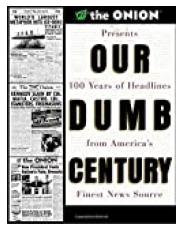

Такие рекомендации


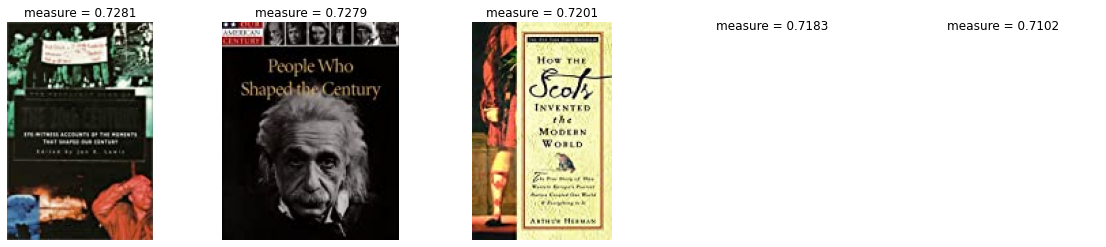

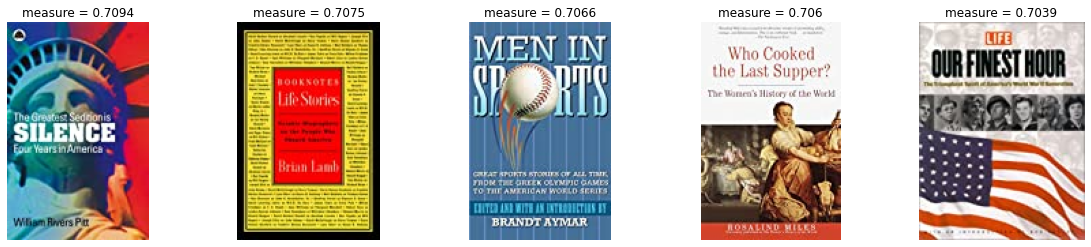

In [41]:
CB.get_rec_I2I(20)

Для пользователя, который взаимодействовал с товарами


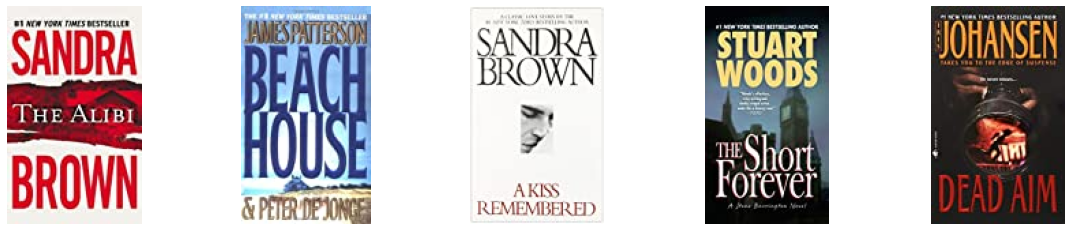

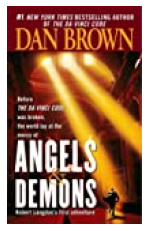

Такие рекомендации


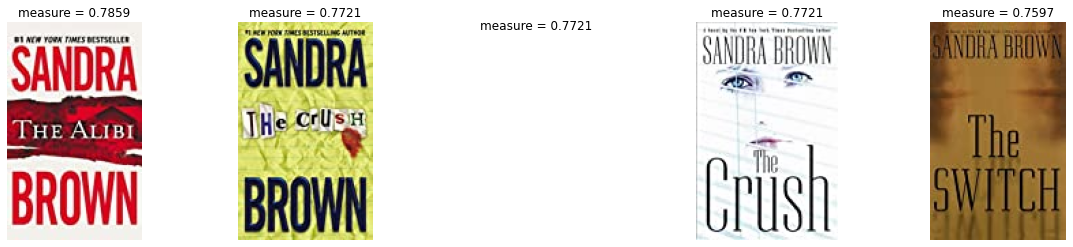

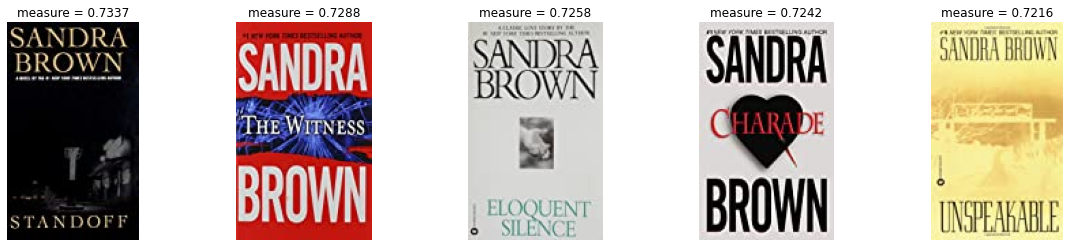

In [42]:
CB.get_rec_U2I(2)

### 3.3 Коллаборативная фильтрация

In [43]:
from sklearn.metrics import pairwise_distances, pairwise_kernels

class Colloborative():
    def __init__(self, interactions, csr_rates):
        self.content_dict = {}
        for i in interactions[["product_id", "picture_url"]].drop_duplicates().values:
            self.content_dict[i[0]] = i[1]
        
        self.csr_rates = csr_rates        

    def user_based(self, idx):
        # получаем рейтинги нашего пользователя
        rates_matrix = self.csr_rates.copy().toarray().astype(float)
        rates_matrix[rates_matrix==0] = np.nan
        
        user_rates = rates_matrix[idx]
        user_rates_mean = np.nanmean(user_rates)
        # отнимаем от рейтингов всех юзеров их средние значения оценок
        all_users_rate_mean = np.nanmean(rates_matrix, axis=1)
        new_rates = rates_matrix - all_users_rate_mean.reshape(-1,1)
        
        user_rates = np.nan_to_num(user_rates)
        new_rates = np.nan_to_num(new_rates)
        rates_matrix = np.nan_to_num(rates_matrix)
        
        watched_items = np.where(user_rates != 0)[0]
        # определяем коэффицент близости нашего пользователя ко всем другим
        metrics = cosine_similarity([user_rates], self.csr_rates).reshape(-1, 1)
        #metrics = pairwise_kernels([user_rates], rates_matrix, metric='cosine').reshape(-1, 1)
        metrics_sum = np.sum(metrics)
        # домножаем оценки пользователей на коэффициент похожести
        rates = new_rates * metrics
        # суммируем оценки по фильмам, при этом, чтобы не рекомендовать уже просмотренные - зануляем веса просмотренных
        total_rate = (1 - user_rates.astype(bool))*(user_rates_mean +np.sum(rates, axis=0)/metrics_sum)
        # печатаем рекомендации
        self.get_rec(watched_items, np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                    np.sort(total_rate)[::-1][:10])
        
    def item_based_I2I(self, idx):
        # получаем рейтинги нашей книги
        rates_matrix = self.csr_rates.copy().toarray().astype(float)
        rates_matrix[rates_matrix==0] = np.nan
        
        item_rates = rates_matrix[:, idx]
        item_rates_mean = np.nanmean(item_rates)
        # отнимаем от рейтингов всех книг их средние значения оценок
        all_items_rate_mean = np.nanmean(rates_matrix, axis=0)
        new_rates = rates_matrix 
        
        item_rates = np.nan_to_num(item_rates)
        new_rates = np.nan_to_num(new_rates)
        rates_matrix = np.nan_to_num(rates_matrix)

        
        # определяем коэффицент близости нашей книги ко всем другим
        metrics = cosine_similarity([item_rates], self.csr_rates.T)

        #metrics = pairwise_distances(item_rates, self.csr_rates.T, metric='cosine')
        metrics_sum = np.sum(metrics)

        # домножаем оценки пользователя на коэффициент похожести
        rates = new_rates * metrics
        total_rate = item_rates_mean + np.sum(rates, axis=0)/metrics_sum
        total_rate[idx] = 0
        # печатаем рекомендации
        self.get_rec([idx], np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                    np.sort(total_rate)[::-1][:10])
        
    def item_based_U2I(self, idx):
        # получаем рейтинги нашего пользователя
        rates_matrix = self.csr_rates.copy().toarray().astype(float)
        rates_matrix[rates_matrix==0] = np.nan
        all_item_rates_mean = np.nanmean(rates_matrix, axis=0)
        rates_matrix = np.nan_to_num(rates_matrix)
        
        user_rates = rates_matrix[idx,:]
        watched_items = np.where(user_rates != 0)[0]
        
        total_rate = np.zeros(user_rates.shape[0])
        
        # Цикл по всем книгам
        for i in tqdm.tqdm_notebook(range(user_rates.shape[0])):
            # Если пользователь уже читал данную книгу, то выставляем отрицательный рейтинг
            if user_rates[i] != 0:
                total_rate[i] = -100
            else:
                item_rates = rates_matrix[:, i]
                metrics = cosine_similarity([item_rates], self.csr_rates.T)[0]
                metrics_sum = np.sum(metrics)
                i_rate = 0
                for j in range(user_rates.shape[0]): 
                    if user_rates[j] != 0:
                        i_rate = i_rate + (user_rates[j] - all_item_rates_mean[j])*metrics[j]
                        
                total_rate[i] = all_item_rates_mean[i] + i_rate/metrics_sum
                
        self.get_rec(watched_items, np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                    np.sort(total_rate)[::-1][:30])
        
        

    def get_rec(self, watched, recs, measure):
        print(u"Для таких товаров")
        rec_imaging([i for i in watched], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging([i for i in recs], self.content_dict, measure)

In [44]:
clb = Colloborative(interactions, csr_rates)

Реализация Item-based по формуле из лекции.

Результаты получаются очень странными. Так как пользователь оценивал книги хуже, чем средний пользователь, поэтому второе слоагаемое в формуле оказывается отрицательным и в итоге в топ выходят фильмы с самым высоким средним рейтингом (т.е. с рейтингом 10, а таких книг 72 штуки)

<ipython-input-43-fe3172c21ab3>:82: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(user_rates.shape[0])):



Для таких товаров


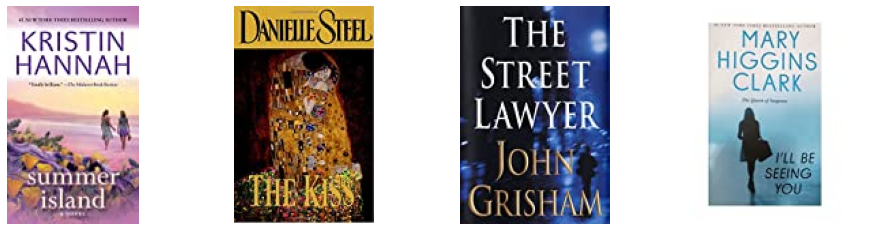

Такие рекомендации


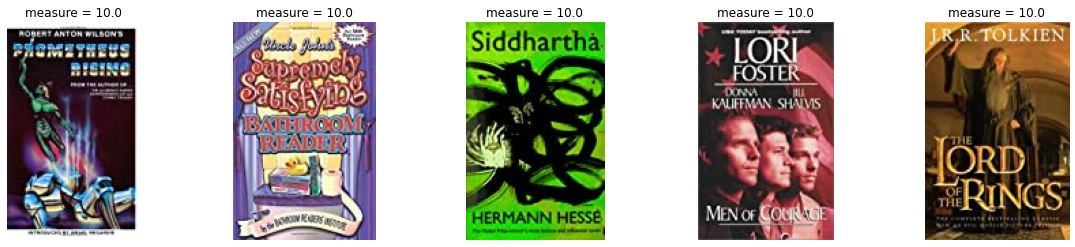

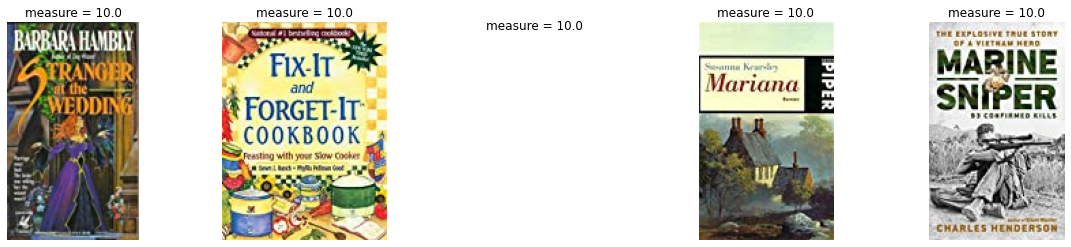

In [45]:
clb.item_based_U2I(12)

Дальше идет user-based коллаборация, как мне кажется, она дает хороший результат

Для таких товаров


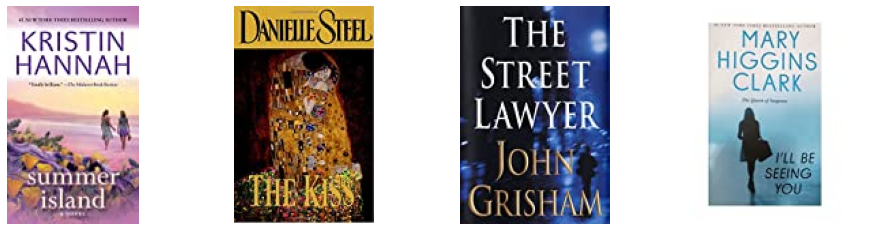

Такие рекомендации


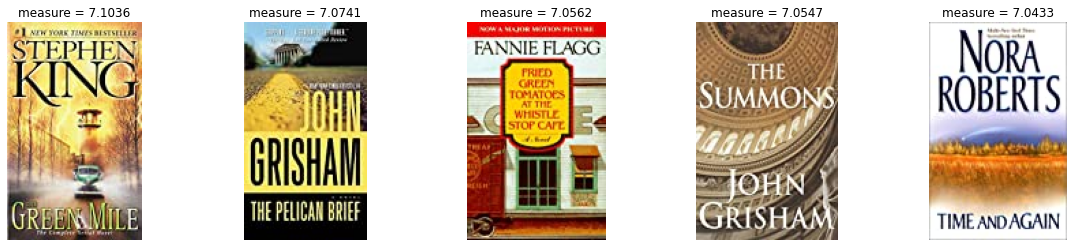

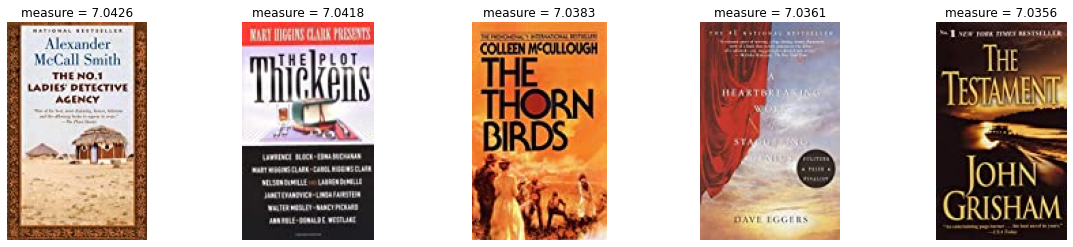

In [46]:
clb.user_based(12)

Дальше попытался сделать I2I item-based. В качестве формулы взял формулу для user-based, только транспонировав матрицу оценок. Единственное, я не отнимал среднее значение, поэтому конечный measure никак не связан с оценками. Но вроде получилось неплохо

Для таких товаров


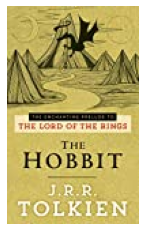

Такие рекомендации


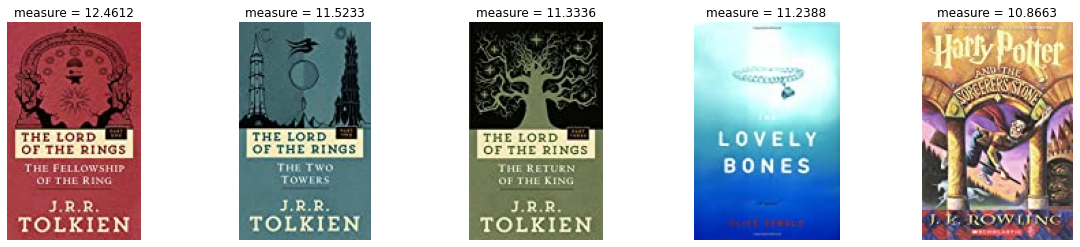

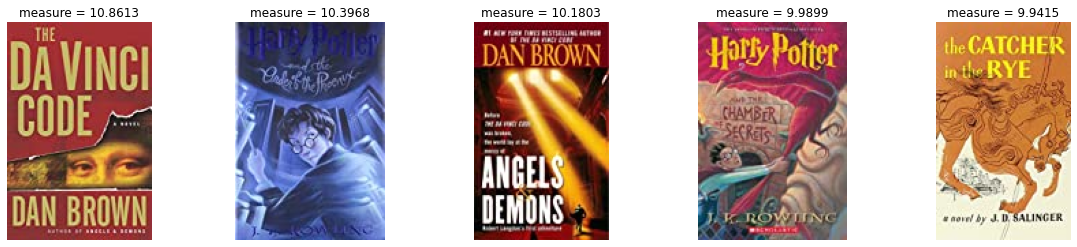

In [47]:
clb.item_based_I2I(1921)

### 3.4 Матричная Факторизация

Здесь только I2I рекомендации (что были на лекции)

In [48]:
class MatrixFactorization():
    
    def __init__(self, interactions, csr_matrix, k):
        interactions["product_id"] = interactions["product_id"].astype(int)
        self.k = k
        self.content_dict = {}
        for i, j in interactions[["product_id", "picture_url"]].drop_duplicates().values:
            self.content_dict[i] = j
        self.csr_rates = csr_matrix
        
    def MF(self):
        U, S, V = svds(self.csr_rates.astype(float), k=self.k)
        self.user_embs = U
        self.items_embs = V.T
        
    def LightFM(self):
        self.model = LightFM(loss='warp', no_components=100, learning_rate=0.03, learning_schedule="adadelta")
        self.model.fit(self.csr_rates, epochs=5, num_threads=40, verbose=True)
        self.user_feature_bias, self.user_feature_embeddings = self.model.get_user_representations()
        self.item_feature_bias, self.items_embs = self.model.get_item_representations()

    def get_rec(self, i):
        metrics = cosine_similarity([self.items_embs[i]], self.items_embs)
        print(u"Для товара")
        rec_imaging([i], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(-metrics)[0][1:11], self.content_dict, -np.round(np.sort(-metrics)[0][1:11], 4))

In [49]:
simple_svd = MatrixFactorization(interactions, csr_rates, 30)
simple_svd.MF()

Для товара


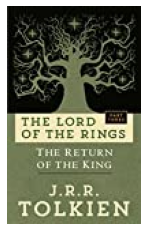

Такие рекомендации


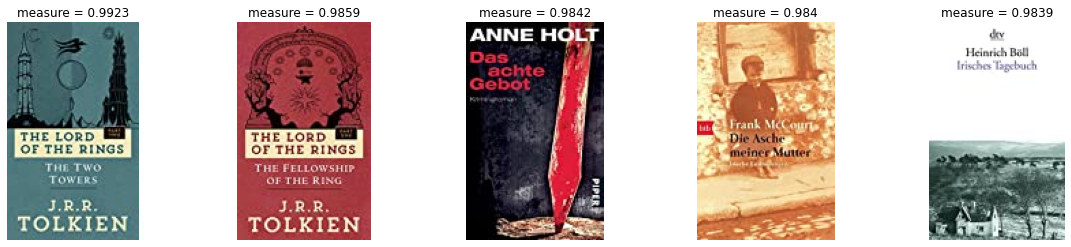

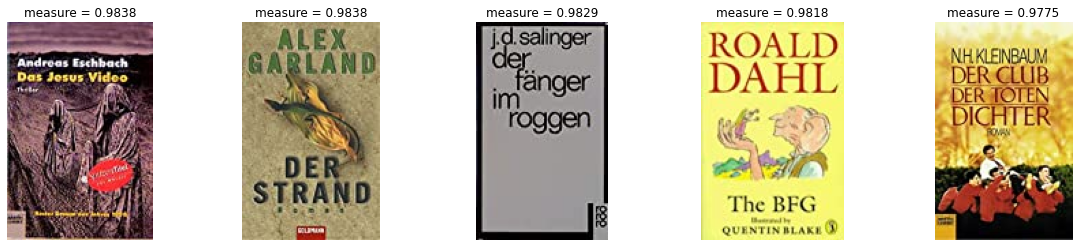

In [50]:
simple_svd.get_rec(1924)